# Initializing All Paramters

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma as gamma_dist, beta as beta_dist, truncnorm
from scipy.special import polygamma

# Load data
data_count = pd.read_csv("Deng_count.csv", index_col=0)
data_type = pd.read_csv("Deng_celltype.csv", index_col=0)
blast_cells = data_type[data_type['cell_type1'] == 'blast']
blast_counts = data_count.loc[:, blast_cells.index]

p_initial = (data_count == 0).mean(axis=1)
mu_initial = data_count[data_count > 0].mean(axis=1)

np.save("p_array.npy", p_initial.values)
np.save("mu_array.npy", mu_initial.values)

p = np.load("p_array.npy")
p = np.clip(p, 0.01, 0.99)
np.save("p_array_clipped.npy", p)

X = np.array(blast_counts.copy())

Z = np.zeros(np.shape(X)) 
p = np.load("p_array_clipped.npy")
mu = np.load("mu_array.npy")
Z_values = []
mu_values = []
p_values = []
alpha_values = []
beta_values = []
k_values = []
theta_values = []

# Gibbs Sampling 
G = X.shape[0]
I = X.shape[1]
print(p)
print(np.shape(p))
print(mu)
print(np.shape(mu))

[0.30970149 0.79104478 0.26492537 ... 0.75       0.84701493 0.15671642]
(11394,)
[388.44864865 326.89285714 982.81725888 ...  10.43283582  16.68292683
 342.09734513]
(11394,)


# Function for Indicator Sampling Z

In [2]:
def indicator_sampling(X, p, mu):
    G, I = X.shape
    non_zero_indices = np.where(X != 0)
    X_1 = X[non_zero_indices] * 0 
    p_extended = np.broadcast_to(p[:, np.newaxis], (G, I)) 
    mu_extended = np.broadcast_to(mu[:, np.newaxis], (G, I))  
    p = (1 - p_extended) * poisson.pmf(X, mu_extended)  
    p_complement = p_extended  
    normalized_p= np.stack([p, p_complement], axis=-1)  
    sum_p = np.sum(normalized_p, axis=2) 
    normalized_p = normalized_p / sum_p[..., np.newaxis] 
    samples = np.apply_along_axis(lambda p: np.random.choice([0, 1], p=p), -1, normalized_p)
    samples[non_zero_indices] = X_1
    return samples



# Function for Distribution of Hyperpriors alpha_g and beta_g

In [3]:
def log_beta_dist(alpha, beta):
    if alpha <= 0 or beta <= 0:
        return -np.inf 
    log_hyperprior = -2.5 * np.log(alpha + beta) 
    log_likelihood = np.sum(beta_dist.logpdf(p, alpha, beta))
    log_posterior_pdf = log_hyperprior + log_likelihood
    return log_posterior_pdf

# Function for Metropolis Hastings Sampling for Hyperpriors alpha_g and beta_g

In [4]:
def metropolis_hastings_alpha_beta(iterations, initial_alpha, initial_beta, proposal_sd):
    samples = np.zeros((iterations, 2)) 
    current_alpha = initial_alpha
    current_beta = initial_beta

    current_posterior = log_beta_dist(current_alpha, current_beta)  # Calculate only once initially

    for i in range(iterations):
        proposed_alpha = np.random.normal(current_alpha, proposal_sd)
        proposed_beta = np.random.normal(current_beta, proposal_sd)
        
        if proposed_alpha <= 0 or proposed_beta <= 0:
            samples[i] = [current_alpha, current_beta]  # Record current values if proposed are invalid
            continue

        proposed_posterior = log_beta_dist(proposed_alpha, proposed_beta)
        acceptance_probability = np.exp(proposed_posterior - current_posterior)

        if acceptance_probability > np.random.rand():
            current_alpha = proposed_alpha
            current_beta = proposed_beta
            current_posterior = proposed_posterior

        samples[i] = [current_alpha, current_beta]

    return samples

# Function for Distribution of Hyperpriors alpha_mu and beta_mu

In [5]:
def sampling_distribution_k_theta(k, theta, mu):
    c = 1/np.sqrt(G)
    lamb = 2/3
    log_k_theta = gamma_dist.logpdf(k, c, scale=lamb)
    log_mu_given_k_theta = np.sum(gamma_dist.logpdf(mu, k, scale=1/theta))
    log_posterior = log_mu_given_k_theta + log_k_theta
    return log_posterior

# Function for Metropolis Hastings Sampling for Hyperpriors k_g and theta_g

In [6]:
def metropolis_hastings_k_theta(mu, initial_k_theta, iterations, proposal_std):
    samples = np.zeros((iterations, 2))
    current_k, current_theta = initial_k_theta
    
    current_logpdf = sampling_distribution_k_theta(current_k, current_theta, mu)
    
    for i in range(iterations):
        proposed_k, proposed_theta = np.random.normal([current_k, current_theta], proposal_std)

        if proposed_k <= 0 or proposed_theta <= 0:
            samples[i] = [current_k, current_theta]
            continue
        
        proposed_logpdf = sampling_distribution_k_theta(proposed_k, proposed_theta, mu)
        
        acceptance_prob = np.exp(proposed_logpdf - current_logpdf)

        
        if np.random.rand() < acceptance_prob:
            current_k = proposed_k
            current_theta = proposed_theta
            current_logpdf = proposed_logpdf
            
        samples[i] = [current_k, current_theta]
    
    return samples

# Gibbs Sampling for Everything

In [7]:
burn_in = 15
for i in range(150): 
    Z = indicator_sampling(X, p, mu)
    Z_values.append(Z) 
          
    initial_alpha = 1
    initial_beta = 1
    iterations = 500
    proposal_sd = 0.1
    list_beta_sampling = metropolis_hastings_alpha_beta(iterations, initial_alpha, initial_beta, proposal_sd)
    alpha = list_beta_sampling[iterations-1, 0]
    beta = list_beta_sampling[iterations-1, 1]

    initial_gamma_sampling = [0.01, 10**(-4)]  
    proposal_std = [0.01/10, 10**(-5)] 
    iterations = 500
    samples = metropolis_hastings_k_theta(mu, initial_gamma_sampling, iterations, proposal_std)
    k = samples[iterations-1, 0]
    theta = samples[iterations-1, 1]
    
    # Samping for Beta distribution for p_g
    for g in range(G):
        n = np.sum(Z[g, :] == 1)
        p[g] = np.random.beta(alpha + n, beta + I - n)

    # Sampling for Gamma distribution for mu_g
    c_values = []
    d_values = []
    for g in range(G):
        c = np.dot(X[g], 1-Z[g])
        d = np.sum(Z[g, :] == 0)
        mu[g] = np.random.gamma(k + c, scale=1/(theta + d))


    if i >= burn_in:
        alpha_values.append(alpha)
        beta_values.append(beta)
        k_values.append(k)
        theta_values.append(theta)
        p_values.append(p.copy()) 
        mu_values.append(mu.copy()) 

    print("Completed iteration", i)


C:\Users\darkr\AppData\Local\Temp\ipykernel_62036\3722901801.py:16: RuntimeWarning: overflow encountered in exp
  acceptance_prob = np.exp(proposed_logpdf - current_logpdf)


Completed iteration 0
Completed iteration 1
Completed iteration 2
Completed iteration 3
Completed iteration 4
Completed iteration 5
Completed iteration 6
Completed iteration 7
Completed iteration 8
Completed iteration 9
Completed iteration 10
Completed iteration 11
Completed iteration 12
Completed iteration 13
Completed iteration 14
Completed iteration 15
Completed iteration 16
Completed iteration 17
Completed iteration 18
Completed iteration 19
Completed iteration 20
Completed iteration 21
Completed iteration 22
Completed iteration 23
Completed iteration 24
Completed iteration 25
Completed iteration 26
Completed iteration 27
Completed iteration 28
Completed iteration 29
Completed iteration 30
Completed iteration 31
Completed iteration 32
Completed iteration 33
Completed iteration 34
Completed iteration 35
Completed iteration 36
Completed iteration 37
Completed iteration 38
Completed iteration 39
Completed iteration 40
Completed iteration 41
Completed iteration 42
Completed iteration 4

In [8]:
# np.save('mu_values.npy', mu_values)        
# np.save('p_values.npy', p_values)       
# np.save('alpha_p_values.npy', alpha_values) 
# np.save('beta_p_values.npy', beta_values)  
# np.save('alpha_mu_values.npy', k_values)         
# np.save('beta_mu_values.npy', theta_values) 

In [17]:
mu_values = np.load('mu_values.npy')
p_values = np.load('p_values.npy')
alpha_p_values = np.load('alpha_p_values.npy')
beta_p_values = np.load('beta_p_values.npy')
alpha_mu_values = np.load('alpha_mu_values.npy')
beta_mu_values = np.load('beta_mu_values.npy')

# Print to confirm
print(mu_values)
print(p_values)
print(alpha_p_values)
print(beta_p_values)
print(alpha_mu_values)
print(beta_mu_values)


[[1.76305742e+02 7.66985266e+00 2.25815564e+02 ... 8.71818345e-01
  4.54342507e-01 4.66580230e+02]
 [1.79696025e+02 4.83956055e+00 2.26211045e+02 ... 8.70721098e-01
  6.76300240e-01 4.67166716e+02]
 [1.78871946e+02 7.33923752e+00 2.26625985e+02 ... 1.01515138e+00
  4.61356978e-01 4.59743691e+02]
 ...
 [1.78930039e+02 7.43736892e+00 2.26442717e+02 ... 7.12196940e-01
  9.15512554e-01 4.68073023e+02]
 [1.78428963e+02 6.26779047e+00 2.25789888e+02 ... 7.25258262e-01
  9.84211461e-01 4.65704097e+02]
 [1.75386923e+02 5.95185115e+00 2.25803147e+02 ... 6.09211417e-01
  1.04008394e+00 4.68475093e+02]]
[[0.38830568 0.94431827 0.50367147 ... 0.43452283 0.87705539 0.14744074]
 [0.2624671  0.93789369 0.48591543 ... 0.56833083 0.84268795 0.14021375]
 [0.29853713 0.94670194 0.456087   ... 0.59082164 0.82686099 0.14749105]
 ...
 [0.42038174 0.94161944 0.44582263 ... 0.55809765 0.86891094 0.14993492]
 [0.34942815 0.90723692 0.5556579  ... 0.47374883 0.85251505 0.12991465]
 [0.33683878 0.95005632 0.4829

# Plotting Results for all Parameters

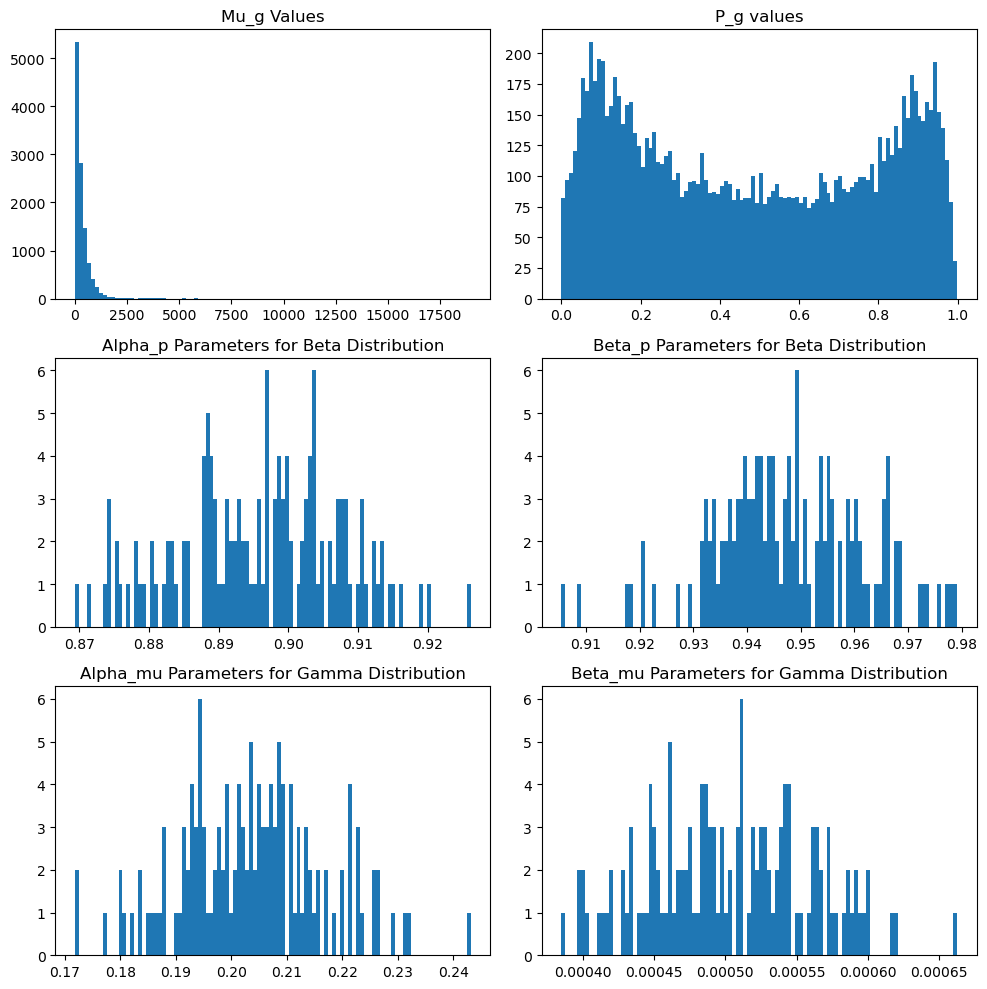

In [10]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs[0, 0].hist(mu, 100)
axs[0, 0].set_title("Mu_g Values")
axs[0, 1].hist(p, 100)
axs[0, 1].set_title("P_g values")
axs[1, 0].hist(alpha_p_values, 100)
axs[1, 0].set_title("Alpha_p Parameters for Beta Distribution")
axs[1, 1].hist(beta_p_values, 100)
axs[1, 1].set_title("Beta_p Parameters for Beta Distribution")
axs[2, 0].hist(alpha_mu_values, 100)
axs[2, 0].set_title("Alpha_mu Parameters for Gamma Distribution")
axs[2, 1].hist(beta_mu_values, 100)
axs[2, 1].set_title("Beta_mu Parameters for Gamma Distribution")
plt.tight_layout()
plt.show()

In [11]:
print(f"Mean of mu: {np.mean(mu_values)}")
print(f"Mean of p: {np.mean(p_values)}")
print(f"Mean of alpha_p: {np.mean(alpha_p_values)}")
print(f"Mean of beta_p: {np.mean(beta_p_values)}")
print(f"Mean of alpha_mu: {np.mean(alpha_mu_values)}")
print(f"Mean of beta_mu: {np.mean(beta_mu_values)}")

Mean of mu: 331.79179092291145
Mean of p: 0.48463125040235244
Mean of alpha_p: 0.896007255569206
Mean of beta_p: 0.9477416134077091
Mean of alpha_mu: 0.20368378183860097
Mean of beta_mu: 0.0005036842122354761


In [12]:
print(f"Standard Deviation of alpha_p: {np.std(alpha_p_values)}")
print(f"Standard Deviation of beta_p: {np.std(beta_p_values)}")
print(f"Standard Deviation of alpha_mu: {np.std(alpha_mu_values)}")
print(f"Standard Deviation of beta_mu: {np.std(beta_mu_values)}")

Standard Deviation of alpha_p: 0.011504760565142196
Standard Deviation of beta_p: 0.013835423245878649
Standard Deviation of alpha_mu: 0.012808699323149765
Standard Deviation of beta_mu: 5.6030235007859415e-05


# Checking for Convergence

# Full Data

In [23]:
initial_data_mean = data_count.mean().mean()

initial_zero_probability = (data_count == 0).mean().mean()

def compute_posterior_predictive_stats(p, mu):
    predictive_mean = np.mean(mu)
    predictive_zero_prob = np.mean(p)
    return predictive_mean, predictive_zero_prob

def check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability, tolerance_mean = 30, tolerance_prob=0.1):
    predictive_mean, predictive_zero_prob = compute_posterior_predictive_stats(p, mu)
    mean_diff = abs(predictive_mean - initial_data_mean)
    zero_prob_diff = abs(predictive_zero_prob - initial_zero_probability)
    print(f"The model's prediction for the mean is: {predictive_mean}")
    print(f"The model's prediction for the zero probability is: {predictive_zero_prob}")
    print(initial_data_mean)
    print(initial_zero_probability)
    if mean_diff < tolerance_mean and zero_prob_diff < tolerance_prob:
        print("Convergence likely achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")
    else:
        print("Convergence not yet achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")

check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability)

The model's prediction for the mean is: 331.7289119096741
The model's prediction for the zero probability is: 0.48308969089057485
332.0669784961449
0.4643564038679693
Convergence likely achieved.
Predictive Mean Difference: 0.3380665864708021, Predictive Zero Probability Difference: 0.01873328702260557


# Blast data

In [13]:
G = data_count.shape[0]
N0 = blast_counts.shape[1]

# Initial data mean
initial_data_mean = blast_counts.mean().mean()

# Probability that the data is 0
initial_zero_probability = (blast_counts == 0).mean().mean()

def compute_posterior_predictive_stats(p, mu):
    predictive_mean = np.mean(mu * (1 - p))
    predictive_zero_prob = np.mean(p + (1 - p) * np.exp(-mu))
    return predictive_mean, predictive_zero_prob

def check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability, tolerance_mean = 30, tolerance_prob=0.01):
    predictive_mean, predictive_zero_prob = compute_posterior_predictive_stats(p, mu)
    mean_diff = abs(predictive_mean - initial_data_mean)
    zero_prob_diff = abs(predictive_zero_prob - initial_zero_probability)
    print(f"The model's prediction for the mean is: {predictive_mean}")
    print(f"The model's prediction for the zero probability is: {predictive_zero_prob}")
    print(initial_data_mean)
    print(initial_zero_probability)
    if mean_diff < tolerance_mean and zero_prob_diff < tolerance_prob:
        print("Convergence likely achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")
    else:
        print("Convergence not yet achieved.")
        print(f"Predictive Mean Difference: {mean_diff}, Predictive Zero Probability Difference: {zero_prob_diff}")

check_convergence(p, mu, data_count, initial_data_mean, initial_zero_probability)

The model's prediction for the mean is: 252.44550788066954
The model's prediction for the zero probability is: 0.4963476372485461
253.64257800900356
0.4962412613946663
Convergence likely achieved.
Predictive Mean Difference: 1.197070128334019, Predictive Zero Probability Difference: 0.00010637585387979209
